In [66]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..")
from src.nce.binary import NceBinaryCrit
from src.nce.cnce import CondNceCrit

from src.noise_distr.normal import MultivariateNormal
from src.noise_distr.conditional_normal import ConditionalMultivariateNormal

from src.models.ring_model.ring_model import RingModel, RingModelNCE
from src.data.ring_model_dataset import RingModelDataset

from src.training.model_training import train_model
from src.training.training_utils import PrecisionErrorMetric, no_change_stopping_condition

In [67]:
# Data specs
num_dims = 5

# Experiments specs
num_samples = [20, 50, 100, 200]
num_neg_samples = [2, 5, 10]
reps = 10

# Criteria 
criteria = [NceBinaryCrit, CondNceCrit]
crit_labels = ["binary", "conditional"]

# Training specs
batch_size = 32
num_epochs = 20

In [68]:
# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/estimation/noise/continous/gNoise.m

def get_cnce_epsilon_factor(y, neg_sample_size, mu, log_precision_init):
    
    loss_zero = np.log(2) # 2 * log(2)  # Loss as epsilon -> 0 
    loss_inf = 0  # Loss as epsilon -> inf
    thrs_lower = 0.05 #0.1  # Epsilon is too large if loss falls below this value
    thrs_upper = 0.5 * loss_zero  # Epsilon is too small if loss goes above 
    inc_rate = 0.2  # Epsilon increase rate
    dec_rate = 0.5  # Epsilon decrease rate
    max_iter = 500  # Maximum allowed iterations
    epsilon_factor = 0.5  # Start value (mutliplied with epsilonBase)
    eps_hard_cap = 1000  # Epsilon is not allowed to increase above this value (in case epsilon goes to 0 very slowly)
    

    num_dims = y.shape[-1]
    p_m = RingModel(mu=mu, log_precision=log_precision_init)  
    
    cov_noise = torch.eye(num_dims) * (epsilon_factor * get_cnce_epsilon_base(y))**2
    p_n = ConditionalMultivariateNormal(cov=cov_noise)
    criterion = CondNceCrit(p_m, p_n)

    # Calculate initial loss
    y_samples = criterion.sample_noise(neg_sample_size * y.shape[0], torch.tensor(y))
    loss = criterion.crit(torch.tensor(y), y_samples)


    # Iterate until conditions are met 
    k = 1;
    while (k < max_iter) and (abs(1 - (loss/loss_zero)) < thrs_lower or loss < thrs_upper ) and (epsilon_factor < eps_hard_cap):

        if abs(1 - (loss/loss_zero)) < thrs_lower: 
            epsilon_factor = (1 + inc_rate) * epsilon_factor
        elif loss < thrs_upper:
            epsilon_factor = (1 - dec_rate) * epsilon_factor
   
        cov_noise = torch.eye(num_dims) * (epsilon_factor * get_cnce_epsilon_base(y))**2
        p_n = ConditionalMultivariateNormal(cov=cov_noise)
        criterion = CondNceCrit(p_m, p_n)
        y_samples = criterion.sample_noise(neg_sample_size * y.shape[0], torch.tensor(y))
        loss = criterion.crit(torch.tensor(y), y_samples)
        
        k = k + 1
    
    return epsilon_factor


In [69]:
# Noise distribution parameters
# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/estimation/noise/continous/gNCEnoise.m
def get_nce_noise_distr_par(y):
    mu = y.mean(axis=0)
    cov = np.cov(y, rowvar=False)
    
    return mu, cov

# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/estimation/noise/continous/gEpsilonBaseFun.m
def get_cnce_epsilon_base(y):
    return np.std(y, axis=-1).mean()

In [70]:

# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/data_generation/generate_parameters.m
def generate_true_params():
    mu_min, mu_max = 5, 10
    sigma_min, sigma_max = 0.3, 1.5
    mu = (mu_max - mu_min) * np.random.uniform() + mu_min
    sigma = (sigma_max - sigma_min) * np.random.uniform() + sigma_min
    precision = sigma**(-2)
    z = -0.5 * np.log(2 * np.pi) - np.log(sigma);
    
    return mu, precision, z

def initialise_params():
    mu_min, mu_max = 6, 8
    sigma_min, sigma_max = 0.3, 1.5
    mu = (mu_max - mu_min) * np.random.uniform() + mu_min
    sigma = (sigma_max - sigma_min) * np.random.uniform() + sigma_min
    precision = sigma**(-2)
    
    z_min = 0.01
    z = np.random.uniform() + z_min

    return mu, np.log(precision), np.log(z)


In [73]:
# Run experiments

error_res = np.zeros((len(num_samples), len(num_neg_samples), len(criteria), reps))

# Sorry för alla loopar
for i, N in enumerate(num_samples):
    
    for j, J in enumerate(num_neg_samples):
        
        for rep in range(reps):
            
            # Get data 
            mu, precision, z = generate_true_params()
            error_metric = PrecisionErrorMetric(true_precision=precision).metric            
                        
            training_data = RingModelDataset(sample_size=N, num_dims=num_dims, mu=mu, precision=precision, 
                                             root_dir="res/datasets/ring_data_size_" + str(N) + "_nn_" + str(J) + "_rep_" + str(rep))
            train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
    
            # Initialise           
            _, log_precision_init, log_z_init = initialise_params()
    
            # Get noise distr. params
            mu_noise_nce, cov_noise_nce = get_nce_noise_distr_par(training_data.y)
            cov_noise_cnce = torch.eye(num_dims) * (get_cnce_epsilon_base(training_data.y) 
                                                    * get_cnce_epsilon_factor(training_data.y, J, mu, log_precision_init))**2
                        
            for k, (crit, lab) in enumerate(zip(criteria, crit_labels)):
            
                if crit == NceBinaryCrit: # TODO: Nicer way to do this comparison?
                    p_m = RingModelNCE(mu=mu, log_precision=log_precision_init, log_part_fn=log_z_init)
                else:
                    p_m = RingModel(mu=mu, log_precision=log_precision_init)
                    
                if crit == CondNceCrit:
                    p_n = ConditionalMultivariateNormal(cov=cov_noise_cnce)
                else:
                    p_n = MultivariateNormal(mu=mu_noise_nce, cov=cov_noise_nce)
                    
                criterion = crit(p_m, p_n)
                
                save_dir = "res/param_error_" + lab + "_samples_" + str(N) + "_num_neg_" + str(J) + "_rep_" + str(rep)
                error_res[i, j, k, rep] = train_model(criterion, error_metric, train_loader, save_dir, neg_sample_size=J, num_epochs=num_epochs,
                                                      stopping_condition=no_change_stopping_condition)

np.save("res/final_param_error_ring_model_all", error_res)

[1] loss: 2.689
[1] evaluation metric: 54.839
[2] loss: 2.899
[2] evaluation metric: 57.691
[3] loss: 2.882
[3] evaluation metric: 60.344
[4] loss: 2.602
[4] evaluation metric: 63.603
[5] loss: 2.427
[5] evaluation metric: 66.868
[6] loss: 2.537
[6] evaluation metric: 70.119
[7] loss: 2.545
[7] evaluation metric: 74.157
[8] loss: 2.234
[8] evaluation metric: 76.182
[9] loss: 2.520
[9] evaluation metric: 78.571
[10] loss: 2.516
[10] evaluation metric: 81.016
[11] loss: 1.866
[11] evaluation metric: 86.142
[12] loss: 1.806
[12] evaluation metric: 89.700
[13] loss: 1.875
[13] evaluation metric: 93.088
[14] loss: 1.462
[14] evaluation metric: 93.796
[15] loss: 1.221
[15] evaluation metric: 96.580
[16] loss: -0.235
[16] evaluation metric: 100.895
[17] loss: -0.961
[17] evaluation metric: 104.837
[18] loss: -3.271
[18] evaluation metric: 106.379
[19] loss: -3.784
[19] evaluation metric: 107.204
[20] loss: -4.874
[20] evaluation metric: 107.658
Finished training
Data saved
[1] loss: 0.420
[1]

[18] loss: 1.633
[18] evaluation metric: 58.178
[19] loss: 0.313
[19] evaluation metric: 60.579
[20] loss: 0.209
[20] evaluation metric: 62.758
Finished training
Data saved
[1] loss: 0.317
[1] evaluation metric: 27.519
[2] loss: 0.525
[2] evaluation metric: 27.411
[3] loss: 0.439
[3] evaluation metric: 27.137
[4] loss: 0.471
[4] evaluation metric: 26.769
[5] loss: 0.420
[5] evaluation metric: 26.479
[6] loss: 0.379
[6] evaluation metric: 26.156
[7] loss: 0.444
[7] evaluation metric: 26.063
[8] loss: 0.398
[8] evaluation metric: 25.831
[9] loss: 0.485
[9] evaluation metric: 25.769
Training converged
Finished training
Data saved
[1] loss: -0.716
[1] evaluation metric: 3.527
[2] loss: -2.324
[2] evaluation metric: 3.737
[3] loss: -1.221
[3] evaluation metric: 4.075
[4] loss: -3.011
[4] evaluation metric: 4.155
[5] loss: -2.208
[5] evaluation metric: 4.325
[6] loss: -3.386
[6] evaluation metric: 4.366
[7] loss: -3.814
[7] evaluation metric: 4.388
[8] loss: -3.866
[8] evaluation metric: 4.4

[19] loss: 0.848
[19] evaluation metric: 0.078
[20] loss: 0.706
[20] evaluation metric: 0.068
Finished training
Data saved
[1] loss: 2.555
[1] evaluation metric: 29.250
[2] loss: 2.435
[2] evaluation metric: 31.096
[3] loss: 2.469
[3] evaluation metric: 32.305
[4] loss: 1.815
[4] evaluation metric: 34.303
[5] loss: 1.396
[5] evaluation metric: 36.899
[6] loss: 1.871
[6] evaluation metric: 38.586
[7] loss: 0.382
[7] evaluation metric: 39.926
[8] loss: -1.298
[8] evaluation metric: 41.024
[9] loss: -1.775
[9] evaluation metric: 41.434
[10] loss: -2.128
[10] evaluation metric: 41.672
[11] loss: -2.029
[11] evaluation metric: 41.925
[12] loss: -2.449
[12] evaluation metric: 42.053
[13] loss: -2.605
[13] evaluation metric: 42.211
[14] loss: -2.668
[14] evaluation metric: 42.327
[15] loss: -3.007
[15] evaluation metric: 42.425
[16] loss: -3.225
[16] evaluation metric: 42.484
[17] loss: -3.611
[17] evaluation metric: 42.523
[18] loss: -3.350
[18] evaluation metric: 42.584
[19] loss: -3.352
[1

[13] loss: 0.805
[13] evaluation metric: 0.378
[14] loss: 0.825
[14] evaluation metric: 0.320
[15] loss: 0.656
[15] evaluation metric: 0.283
[16] loss: 0.753
[16] evaluation metric: 0.249
[17] loss: 0.794
[17] evaluation metric: 0.220
[18] loss: 0.652
[18] evaluation metric: 0.205
[19] loss: 0.610
[19] evaluation metric: 0.192
[20] loss: 0.717
[20] evaluation metric: 0.169
Finished training
Data saved
[1] loss: 3.819
[1] evaluation metric: 2.689
[2] loss: 3.855
[2] evaluation metric: 3.131
[3] loss: 3.676
[3] evaluation metric: 3.556
[4] loss: 3.546
[4] evaluation metric: 3.917
[5] loss: 3.576
[5] evaluation metric: 4.399
[6] loss: 3.682
[6] evaluation metric: 4.857
[7] loss: 3.698
[7] evaluation metric: 5.274
[8] loss: 3.588
[8] evaluation metric: 5.713
[9] loss: 3.519
[9] evaluation metric: 6.322
[10] loss: 3.537
[10] evaluation metric: 6.843
[11] loss: 3.379
[11] evaluation metric: 7.462
[12] loss: 3.324
[12] evaluation metric: 8.008
[13] loss: 3.154
[13] evaluation metric: 8.833
[1

[19] evaluation metric: 0.399
[20] loss: -1.382
[20] evaluation metric: 0.403
Finished training
Data saved
[1] loss: 0.593
[1] evaluation metric: 0.046
[2] loss: 0.560
[2] evaluation metric: 0.045
[3] loss: 0.574
[3] evaluation metric: 0.044
[4] loss: 0.588
[4] evaluation metric: 0.043
[5] loss: 0.563
[5] evaluation metric: 0.042
[6] loss: 0.600
[6] evaluation metric: 0.041
[7] loss: 0.583
[7] evaluation metric: 0.041
[8] loss: 0.557
[8] evaluation metric: 0.039
[9] loss: 0.573
[9] evaluation metric: 0.039
[10] loss: 0.556
[10] evaluation metric: 0.038
[11] loss: 0.571
[11] evaluation metric: 0.037
[12] loss: 0.582
[12] evaluation metric: 0.036
[13] loss: 0.554
[13] evaluation metric: 0.034
[14] loss: 0.565
[14] evaluation metric: 0.034
[15] loss: 0.578
[15] evaluation metric: 0.033
[16] loss: 0.557
[16] evaluation metric: 0.032
[17] loss: 0.595
[17] evaluation metric: 0.031
[18] loss: 0.606
[18] evaluation metric: 0.031
[19] loss: 0.569
[19] evaluation metric: 0.030
[20] loss: 0.591
[

[20] loss: 0.439
[20] evaluation metric: 16.622
Finished training
Data saved
[1] loss: 4.871
[1] evaluation metric: 1.616
[2] loss: 5.408
[2] evaluation metric: 0.753
[3] loss: 4.549
[3] evaluation metric: 0.138
[4] loss: 2.554
[4] evaluation metric: 0.003
[5] loss: 2.773
[5] evaluation metric: 0.337
[6] loss: -0.094
[6] evaluation metric: 0.926
[7] loss: -4.627
[7] evaluation metric: 1.325
[8] loss: -7.150
[8] evaluation metric: 1.424
[9] loss: -6.907
[9] evaluation metric: 1.567
[10] loss: -6.918
[10] evaluation metric: 1.662
[11] loss: -8.341
[11] evaluation metric: 1.704
[12] loss: -8.881
[12] evaluation metric: 1.736
[13] loss: -8.895
[13] evaluation metric: 1.774
[14] loss: -9.749
[14] evaluation metric: 1.806
[15] loss: -10.646
[15] evaluation metric: 1.823
[16] loss: -10.883
[16] evaluation metric: 1.837
[17] loss: -11.266
[17] evaluation metric: 1.851
[18] loss: -11.645
[18] evaluation metric: 1.861
[19] loss: -12.085
[19] evaluation metric: 1.870
[20] loss: -12.220
[20] evalu

[1] loss: 1.098
[1] evaluation metric: 0.027
[2] loss: -1.434
[2] evaluation metric: 0.135
[3] loss: -2.752
[3] evaluation metric: 0.206
[4] loss: -2.774
[4] evaluation metric: 0.301
[5] loss: -4.132
[5] evaluation metric: 0.345
[6] loss: -4.276
[6] evaluation metric: 0.388
[7] loss: -5.184
[7] evaluation metric: 0.414
[8] loss: -5.328
[8] evaluation metric: 0.434
[9] loss: -6.066
[9] evaluation metric: 0.452
[10] loss: -6.419
[10] evaluation metric: 0.470
[11] loss: -6.522
[11] evaluation metric: 0.486
[12] loss: -7.256
[12] evaluation metric: 0.504
[13] loss: -8.321
[13] evaluation metric: 0.511
[14] loss: -7.900
[14] evaluation metric: 0.526
[15] loss: -8.314
[15] evaluation metric: 0.535
[16] loss: -9.036
[16] evaluation metric: 0.545
[17] loss: -9.580
[17] evaluation metric: 0.551
[18] loss: -9.831
[18] evaluation metric: 0.557
[19] loss: -10.366
[19] evaluation metric: 0.562
[20] loss: -10.620
[20] evaluation metric: 0.568
Finished training
Data saved
[1] loss: 1.172
[1] evaluati

[5] loss: 0.857
[5] evaluation metric: 26.717
[6] loss: 0.865
[6] evaluation metric: 26.298
[7] loss: 0.786
[7] evaluation metric: 25.899
[8] loss: 0.903
[8] evaluation metric: 25.527
[9] loss: 0.879
[9] evaluation metric: 25.112
[10] loss: 0.895
[10] evaluation metric: 24.751
[11] loss: 0.942
[11] evaluation metric: 24.468
[12] loss: 0.811
[12] evaluation metric: 24.070
[13] loss: 0.838
[13] evaluation metric: 23.690
[14] loss: 0.926
[14] evaluation metric: 23.336
[15] loss: 0.821
[15] evaluation metric: 22.831
[16] loss: 0.769
[16] evaluation metric: 22.409
[17] loss: 0.825
[17] evaluation metric: 22.001
[18] loss: 0.876
[18] evaluation metric: 21.618
[19] loss: 0.775
[19] evaluation metric: 21.186
[20] loss: 0.827
[20] evaluation metric: 20.773
Finished training
Data saved
[1] loss: 3.855
[1] evaluation metric: 0.001
[2] loss: 3.208
[2] evaluation metric: 0.028
[3] loss: 0.941
[3] evaluation metric: 0.080
[4] loss: -0.982
[4] evaluation metric: 0.110
[5] loss: -2.467
[5] evaluation 

[4] loss: 1.037
[4] evaluation metric: 6.201
[5] loss: 0.943
[5] evaluation metric: 5.254
[6] loss: 0.847
[6] evaluation metric: 4.594
[7] loss: 1.113
[7] evaluation metric: 3.567
[8] loss: 0.953
[8] evaluation metric: 3.001
[9] loss: 0.896
[9] evaluation metric: 2.560
[10] loss: 0.901
[10] evaluation metric: 2.165
[11] loss: 0.749
[11] evaluation metric: 1.947
[12] loss: 1.008
[12] evaluation metric: 1.577
[13] loss: 0.907
[13] evaluation metric: 1.355
[14] loss: 0.871
[14] evaluation metric: 1.127
[15] loss: 0.760
[15] evaluation metric: 1.030
[16] loss: 0.899
[16] evaluation metric: 0.863
[17] loss: 0.754
[17] evaluation metric: 0.762
[18] loss: 0.772
[18] evaluation metric: 0.685
[19] loss: 1.088
[19] evaluation metric: 0.503
[20] loss: 0.692
[20] evaluation metric: 0.453
Finished training
Data saved
[1] loss: 4.175
[1] evaluation metric: 0.000
[2] loss: 1.707
[2] evaluation metric: 0.043
[3] loss: -1.052
[3] evaluation metric: 0.088
[4] loss: -2.069
[4] evaluation metric: 0.120
[5

[11] loss: -6.370
[11] evaluation metric: 2.345
[12] loss: -6.705
[12] evaluation metric: 2.352
[13] loss: -7.069
[13] evaluation metric: 2.359
[14] loss: -7.668
[14] evaluation metric: 2.365
[15] loss: -8.147
[15] evaluation metric: 2.370
[16] loss: -8.441
[16] evaluation metric: 2.375
[17] loss: -8.834
[17] evaluation metric: 2.379
[18] loss: -9.211
[18] evaluation metric: 2.383
[19] loss: -9.578
[19] evaluation metric: 2.387
[20] loss: -10.045
[20] evaluation metric: 2.390
Finished training
Data saved
[1] loss: 0.926
[1] evaluation metric: 1.128
[2] loss: 0.925
[2] evaluation metric: 1.105
[3] loss: 0.953
[3] evaluation metric: 1.083
[4] loss: 0.930
[4] evaluation metric: 1.060
[5] loss: 0.889
[5] evaluation metric: 1.037
[6] loss: 0.859
[6] evaluation metric: 1.013
[7] loss: 0.937
[7] evaluation metric: 0.991
[8] loss: 0.955
[8] evaluation metric: 0.969
[9] loss: 0.925
[9] evaluation metric: 0.947
[10] loss: 0.858
[10] evaluation metric: 0.922
[11] loss: 0.866
[11] evaluation metri

[11] loss: -7.272
[11] evaluation metric: 7.742
[12] loss: -7.888
[12] evaluation metric: 7.758
[13] loss: -8.239
[13] evaluation metric: 7.773
[14] loss: -8.819
[14] evaluation metric: 7.784
[15] loss: -9.099
[15] evaluation metric: 7.795
[16] loss: -9.910
[16] evaluation metric: 7.803
[17] loss: -10.099
[17] evaluation metric: 7.811
[18] loss: -10.262
[18] evaluation metric: 7.819
[19] loss: -10.758
[19] evaluation metric: 7.826
[20] loss: -11.413
[20] evaluation metric: 7.831
Finished training
Data saved
[1] loss: 0.821
[1] evaluation metric: 4.410
[2] loss: 0.846
[2] evaluation metric: 4.343
[3] loss: 0.814
[3] evaluation metric: 4.274
[4] loss: 0.858
[4] evaluation metric: 4.205
[5] loss: 0.813
[5] evaluation metric: 4.128
[6] loss: 0.845
[6] evaluation metric: 4.061
[7] loss: 0.816
[7] evaluation metric: 3.988
[8] loss: 0.824
[8] evaluation metric: 3.923
[9] loss: 0.751
[9] evaluation metric: 3.844
[10] loss: 0.823
[10] evaluation metric: 3.770
[11] loss: 0.792
[11] evaluation me

[9] loss: -27.460
[9] evaluation metric: 0.179
[10] loss: -29.597
[10] evaluation metric: 0.183
[11] loss: -31.509
[11] evaluation metric: 0.185
[12] loss: -32.761
[12] evaluation metric: 0.188
[13] loss: -33.837
[13] evaluation metric: 0.191
[14] loss: -35.103
[14] evaluation metric: 0.193
[15] loss: -37.978
[15] evaluation metric: 0.195
[16] loss: -39.256
[16] evaluation metric: 0.196
[17] loss: -40.902
[17] evaluation metric: 0.198
[18] loss: -41.928
[18] evaluation metric: 0.199
[19] loss: -44.993
[19] evaluation metric: 0.200
[20] loss: -45.928
[20] evaluation metric: 0.201
Finished training
Data saved
[1] loss: 7.779
[1] evaluation metric: 2.459
[2] loss: 2.705
[2] evaluation metric: 1.815
[3] loss: 3.133
[3] evaluation metric: 1.170
[4] loss: 3.196
[4] evaluation metric: 0.748
[5] loss: 2.944
[5] evaluation metric: 0.510
[6] loss: 3.350
[6] evaluation metric: 0.285
[7] loss: 3.002
[7] evaluation metric: 0.195
[8] loss: 2.677
[8] evaluation metric: 0.154
[9] loss: 2.786
[9] evalu

[7] loss: 1.788
[7] evaluation metric: 17.863
[8] loss: 1.820
[8] evaluation metric: 17.498
[9] loss: 1.856
[9] evaluation metric: 17.149
[10] loss: 1.874
[10] evaluation metric: 16.866
[11] loss: 1.706
[11] evaluation metric: 16.453
[12] loss: 1.655
[12] evaluation metric: 16.060
[13] loss: 1.696
[13] evaluation metric: 15.701
[14] loss: 1.585
[14] evaluation metric: 15.230
[15] loss: 1.679
[15] evaluation metric: 14.805
[16] loss: 1.845
[16] evaluation metric: 14.500
[17] loss: 1.703
[17] evaluation metric: 14.088
[18] loss: 1.722
[18] evaluation metric: 13.705
[19] loss: 1.639
[19] evaluation metric: 13.357
[20] loss: 1.636
[20] evaluation metric: 13.063
Finished training
Data saved
[1] loss: 11.398
[1] evaluation metric: 5.078
[2] loss: 11.346
[2] evaluation metric: 1.787
[3] loss: 10.276
[3] evaluation metric: 0.376
[4] loss: 9.786
[4] evaluation metric: 0.005
[5] loss: 6.475
[5] evaluation metric: 0.707
[6] loss: -13.560
[6] evaluation metric: 1.379
[7] loss: -22.218
[7] evaluati

[11] loss: -23.520
[11] evaluation metric: 0.339
[12] loss: -25.605
[12] evaluation metric: 0.343
[13] loss: -27.271
[13] evaluation metric: 0.346
[14] loss: -29.087
[14] evaluation metric: 0.349
[15] loss: -30.688
[15] evaluation metric: 0.351
[16] loss: -32.693
[16] evaluation metric: 0.354
[17] loss: -34.092
[17] evaluation metric: 0.355
[18] loss: -35.411
[18] evaluation metric: 0.358
[19] loss: -36.669
[19] evaluation metric: 0.360
[20] loss: -38.949
[20] evaluation metric: 0.361
Finished training
Data saved
[1] loss: 2.252
[1] evaluation metric: 0.000
[2] loss: 2.276
[2] evaluation metric: 0.000
[3] loss: 2.360
[3] evaluation metric: 0.000
[4] loss: 2.306
[4] evaluation metric: 0.000
[5] loss: 2.324
[5] evaluation metric: 0.001
[6] loss: 2.291
[6] evaluation metric: 0.000
[7] loss: 2.369
[7] evaluation metric: 0.000
[8] loss: 2.188
[8] evaluation metric: 0.000
[9] loss: 2.286
[9] evaluation metric: 0.000
[10] loss: 2.363
[10] evaluation metric: 0.000
[11] loss: 2.189
[11] evaluat

[3] loss: 2.834
[3] evaluation metric: 0.282
[4] loss: 2.622
[4] evaluation metric: 0.215
[5] loss: 2.763
[5] evaluation metric: 0.160
[6] loss: 2.414
[6] evaluation metric: 0.124
[7] loss: 2.674
[7] evaluation metric: 0.086
[8] loss: 2.782
[8] evaluation metric: 0.059
[9] loss: 2.383
[9] evaluation metric: 0.052
[10] loss: 3.028
[10] evaluation metric: 0.029
[11] loss: 2.793
[11] evaluation metric: 0.019
[12] loss: 2.449
[12] evaluation metric: 0.015
[13] loss: 2.566
[13] evaluation metric: 0.011
[14] loss: 2.553
[14] evaluation metric: 0.008
[15] loss: 2.492
[15] evaluation metric: 0.006
[16] loss: 2.435
[16] evaluation metric: 0.005
[17] loss: 2.710
[17] evaluation metric: 0.002
[18] loss: 2.531
[18] evaluation metric: 0.001
[19] loss: 2.463
[19] evaluation metric: 0.001
[20] loss: 2.597
[20] evaluation metric: 0.000
Finished training
Data saved
[1] loss: 14.306
[1] evaluation metric: 18.551
[2] loss: 12.891
[2] evaluation metric: 22.721
[3] loss: 12.398
[3] evaluation metric: 29.12

[16] loss: -28.531
[16] evaluation metric: 0.240
[17] loss: -30.189
[17] evaluation metric: 0.241
[18] loss: -31.487
[18] evaluation metric: 0.242
[19] loss: -32.906
[19] evaluation metric: 0.243
[20] loss: -35.146
[20] evaluation metric: 0.244
Finished training
Data saved
[1] loss: 2.373
[1] evaluation metric: 0.092
[2] loss: 2.121
[2] evaluation metric: 0.070
[3] loss: 2.380
[3] evaluation metric: 0.048
[4] loss: 2.045
[4] evaluation metric: 0.040
[5] loss: 2.373
[5] evaluation metric: 0.024
[6] loss: 2.037
[6] evaluation metric: 0.021
[7] loss: 2.014
[7] evaluation metric: 0.017
[8] loss: 2.092
[8] evaluation metric: 0.013
[9] loss: 2.285
[9] evaluation metric: 0.008
[10] loss: 2.443
[10] evaluation metric: 0.004
[11] loss: 2.373
[11] evaluation metric: 0.002
[12] loss: 2.070
[12] evaluation metric: 0.001
[13] loss: 2.080
[13] evaluation metric: 0.001
Training converged
Finished training
Data saved
[1] loss: 7.030
[1] evaluation metric: 0.925
[2] loss: 3.450
[2] evaluation metric: 1

[10] loss: -18.056
[10] evaluation metric: 7.043
[11] loss: -19.852
[11] evaluation metric: 7.056
[12] loss: -21.346
[12] evaluation metric: 7.067
[13] loss: -22.915
[13] evaluation metric: 7.078
[14] loss: -24.698
[14] evaluation metric: 7.086
[15] loss: -26.425
[15] evaluation metric: 7.093
[16] loss: -28.399
[16] evaluation metric: 7.099
[17] loss: -29.502
[17] evaluation metric: 7.105
[18] loss: -31.103
[18] evaluation metric: 7.110
[19] loss: -33.257
[19] evaluation metric: 7.114
[20] loss: -34.611
[20] evaluation metric: 7.118
Finished training
Data saved
[1] loss: 2.273
[1] evaluation metric: 1.333
Training converged
Finished training
Data saved
[1] loss: 18.027
[1] evaluation metric: 3.067
[2] loss: 21.072
[2] evaluation metric: 0.103
[3] loss: 0.872
[3] evaluation metric: 0.168
[4] loss: -3.060
[4] evaluation metric: 0.193
[5] loss: -4.954
[5] evaluation metric: 0.207
[6] loss: -7.351
[6] evaluation metric: 0.214
[7] loss: -9.705
[7] evaluation metric: 0.219
[8] loss: -11.093


[10] loss: -54.144
[10] evaluation metric: 0.725
[11] loss: -59.960
[11] evaluation metric: 0.734
[12] loss: -64.958
[12] evaluation metric: 0.742
[13] loss: -69.714
[13] evaluation metric: 0.749
[14] loss: -74.589
[14] evaluation metric: 0.756
[15] loss: -79.544
[15] evaluation metric: 0.761
[16] loss: -85.536
[16] evaluation metric: 0.765
[17] loss: -89.207
[17] evaluation metric: 0.770
[18] loss: -95.130
[18] evaluation metric: 0.773
[19] loss: -100.164
[19] evaluation metric: 0.776
[20] loss: -104.366
[20] evaluation metric: 0.778
Finished training
Data saved
[1] loss: 7.764
[1] evaluation metric: 9.534
[2] loss: 5.110
[2] evaluation metric: 4.689
[3] loss: 5.320
[3] evaluation metric: 2.229
[4] loss: 4.889
[4] evaluation metric: 1.324
[5] loss: 4.098
[5] evaluation metric: 0.987
[6] loss: 4.314
[6] evaluation metric: 0.670
[7] loss: 4.222
[7] evaluation metric: 0.475
[8] loss: 3.954
[8] evaluation metric: 0.375
[9] loss: 4.198
[9] evaluation metric: 0.288
[10] loss: 4.218
[10] eva

[17] loss: 4.316
[17] evaluation metric: 0.005
[18] loss: 4.032
[18] evaluation metric: 0.004
[19] loss: 4.238
[19] evaluation metric: 0.002
[20] loss: 4.077
[20] evaluation metric: 0.002
Finished training
Data saved
[1] loss: 1.240
[1] evaluation metric: 0.289
[2] loss: -32.619
[2] evaluation metric: 0.359
[3] loss: -39.360
[3] evaluation metric: 0.383
[4] loss: -44.916
[4] evaluation metric: 0.395
[5] loss: -50.187
[5] evaluation metric: 0.404
[6] loss: -54.700
[6] evaluation metric: 0.410
[7] loss: -60.439
[7] evaluation metric: 0.414
[8] loss: -65.189
[8] evaluation metric: 0.418
[9] loss: -70.883
[9] evaluation metric: 0.421
[10] loss: -74.893
[10] evaluation metric: 0.424
[11] loss: -80.484
[11] evaluation metric: 0.426
[12] loss: -85.419
[12] evaluation metric: 0.428
[13] loss: -90.365
[13] evaluation metric: 0.429
[14] loss: -95.683
[14] evaluation metric: 0.430
[15] loss: -99.946
[15] evaluation metric: 0.431
[16] loss: -104.495
[16] evaluation metric: 0.432
[17] loss: -109.36

[11] loss: 4.155
[11] evaluation metric: 0.001
[12] loss: 4.067
[12] evaluation metric: 0.000
[13] loss: 4.203
[13] evaluation metric: 0.000
[14] loss: 4.165
[14] evaluation metric: 0.000
[15] loss: 4.001
[15] evaluation metric: 0.001
[16] loss: 4.040
[16] evaluation metric: 0.001
[17] loss: 4.194
[17] evaluation metric: 0.002
[18] loss: 4.038
[18] evaluation metric: 0.003
[19] loss: 4.098
[19] evaluation metric: 0.004
[20] loss: 4.141
[20] evaluation metric: 0.004
Finished training
Data saved
[1] loss: 18.620
[1] evaluation metric: 12.863
[2] loss: 6.859
[2] evaluation metric: 16.187
[3] loss: -3.797
[3] evaluation metric: 16.984
[4] loss: -9.513
[4] evaluation metric: 17.352
[5] loss: -14.838
[5] evaluation metric: 17.574
[6] loss: -20.406
[6] evaluation metric: 17.711
[7] loss: -25.542
[7] evaluation metric: 17.809
[8] loss: -30.848
[8] evaluation metric: 17.876
[9] loss: -35.768
[9] evaluation metric: 17.933
[10] loss: -40.522
[10] evaluation metric: 17.980
[11] loss: -46.077
[11] 

[4] loss: 3.602
[4] evaluation metric: 1.577
[5] loss: 3.518
[5] evaluation metric: 1.141
[6] loss: 3.572
[6] evaluation metric: 0.871
[7] loss: 3.918
[7] evaluation metric: 0.525
[8] loss: 3.428
[8] evaluation metric: 0.431
[9] loss: 3.491
[9] evaluation metric: 0.336
[10] loss: 3.531
[10] evaluation metric: 0.266
[11] loss: 3.655
[11] evaluation metric: 0.190
[12] loss: 3.477
[12] evaluation metric: 0.153
[13] loss: 3.380
[13] evaluation metric: 0.131
[14] loss: 3.313
[14] evaluation metric: 0.127
[15] loss: 3.432
[15] evaluation metric: 0.114
[16] loss: 3.345
[16] evaluation metric: 0.110
[17] loss: 3.554
[17] evaluation metric: 0.087
[18] loss: 3.438
[18] evaluation metric: 0.075
[19] loss: 3.448
[19] evaluation metric: 0.068
[20] loss: 3.205
[20] evaluation metric: 0.072
Finished training
Data saved
[1] loss: 3.604
[1] evaluation metric: 0.677
[2] loss: -13.798
[2] evaluation metric: 0.765
[3] loss: -19.625
[3] evaluation metric: 0.808
[4] loss: -25.823
[4] evaluation metric: 0.82

[5] loss: -6.721
[5] evaluation metric: 2.004
[6] loss: -12.317
[6] evaluation metric: 2.082
[7] loss: -17.444
[7] evaluation metric: 2.137
[8] loss: -22.509
[8] evaluation metric: 2.175
[9] loss: -27.177
[9] evaluation metric: 2.206
[10] loss: -32.416
[10] evaluation metric: 2.229
[11] loss: -37.753
[11] evaluation metric: 2.246
[12] loss: -42.272
[12] evaluation metric: 2.262
[13] loss: -47.213
[13] evaluation metric: 2.276
[14] loss: -52.451
[14] evaluation metric: 2.287
[15] loss: -57.500
[15] evaluation metric: 2.296
[16] loss: -62.306
[16] evaluation metric: 2.304
[17] loss: -67.390
[17] evaluation metric: 2.311
[18] loss: -71.942
[18] evaluation metric: 2.318
[19] loss: -77.141
[19] evaluation metric: 2.323
[20] loss: -82.160
[20] evaluation metric: 2.329
Finished training
Data saved
[1] loss: 5.946
[1] evaluation metric: 16.264
[2] loss: 5.606
[2] evaluation metric: 6.427
[3] loss: 4.719
[3] evaluation metric: 3.604
[4] loss: 4.490
[4] evaluation metric: 2.150
[5] loss: 4.009
[

[1] loss: 4.244
[1] evaluation metric: 2.150
[2] loss: 3.806
[2] evaluation metric: 1.244
[3] loss: 3.779
[3] evaluation metric: 0.718
[4] loss: 3.579
[4] evaluation metric: 0.441
[5] loss: 3.478
[5] evaluation metric: 0.271
[6] loss: 3.632
[6] evaluation metric: 0.153
[7] loss: 3.306
[7] evaluation metric: 0.105
[8] loss: 3.489
[8] evaluation metric: 0.068
[9] loss: 3.439
[9] evaluation metric: 0.043
[10] loss: 3.232
[10] evaluation metric: 0.031
[11] loss: 3.380
[11] evaluation metric: 0.017
[12] loss: 3.381
[12] evaluation metric: 0.007
[13] loss: 3.475
[13] evaluation metric: 0.003
[14] loss: 3.171
[14] evaluation metric: 0.002
[15] loss: 3.339
[15] evaluation metric: 0.001
[16] loss: 3.207
[16] evaluation metric: 0.001
[17] loss: 3.248
[17] evaluation metric: 0.000
[18] loss: 3.341
[18] evaluation metric: 0.000
[19] loss: 3.377
[19] evaluation metric: 0.000
[20] loss: 3.201
[20] evaluation metric: 0.000
Finished training
Data saved
[1] loss: 21.162
[1] evaluation metric: 0.016
[2]

[3] loss: -0.140
[3] evaluation metric: 13.385
[4] loss: -5.712
[4] evaluation metric: 13.603
[5] loss: -10.870
[5] evaluation metric: 13.752
[6] loss: -15.980
[6] evaluation metric: 13.858
[7] loss: -20.860
[7] evaluation metric: 13.939
[8] loss: -26.614
[8] evaluation metric: 13.994
[9] loss: -30.960
[9] evaluation metric: 14.043
[10] loss: -36.431
[10] evaluation metric: 14.081
[11] loss: -41.259
[11] evaluation metric: 14.112
[12] loss: -46.170
[12] evaluation metric: 14.139
[13] loss: -51.183
[13] evaluation metric: 14.162
[14] loss: -55.953
[14] evaluation metric: 14.181
[15] loss: -60.956
[15] evaluation metric: 14.199
[16] loss: -65.772
[16] evaluation metric: 14.214
[17] loss: -70.725
[17] evaluation metric: 14.229
[18] loss: -75.927
[18] evaluation metric: 14.242
[19] loss: -80.476
[19] evaluation metric: 14.253
[20] loss: -85.226
[20] evaluation metric: 14.263
Finished training
Data saved
[1] loss: 3.739
[1] evaluation metric: 8.113
[2] loss: 3.656
[2] evaluation metric: 7.7

In [72]:
# For visualising results
def plot_res(x, error, label, col, ax):
    ax.plot(x, np.mean(error, axis=-1), color=col, linewidth=1.0, marker='o', label=label)

    ax.fill_between(x, np.min(error, axis=-1), np.max(error, axis=-1), alpha=0.1, color=col)

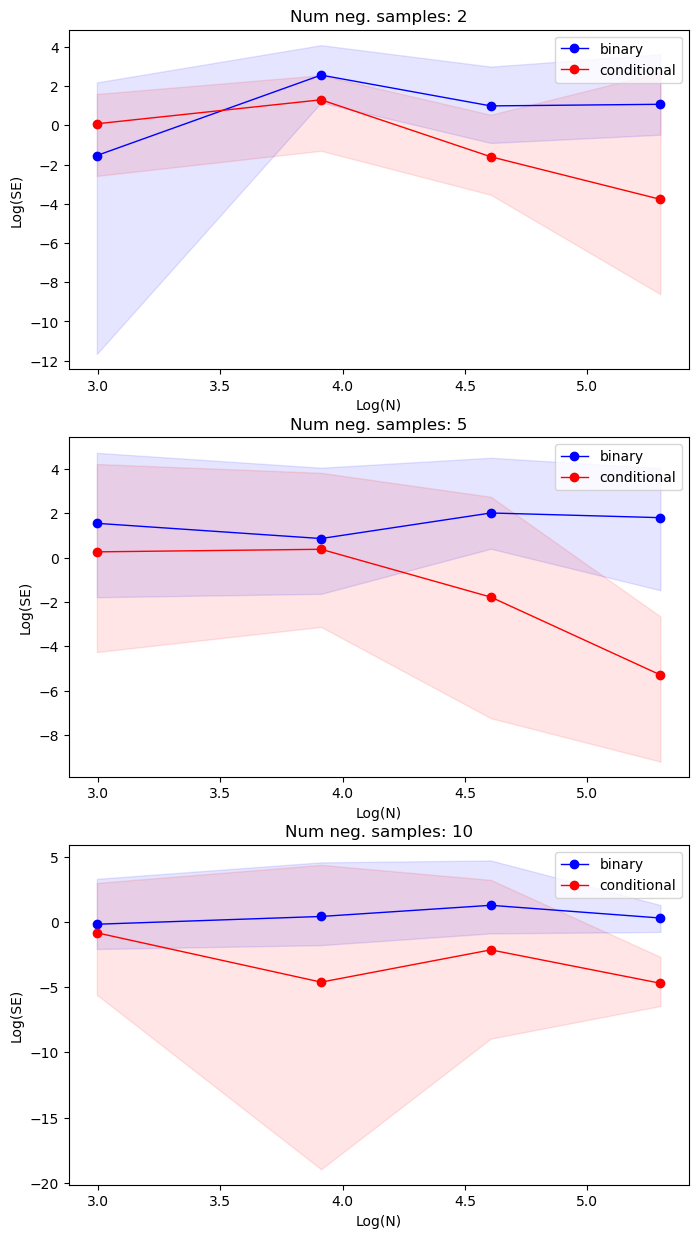

In [65]:
# Visualise results

error_res = np.load("res/final_param_error_ring_model_all.npy")

fig, ax = plt.subplots(len(num_neg_samples), 1, figsize=(8, 15))
colors = ['b', 'r']

log_num_samples = np.log(np.array(num_samples))
for j, axis in enumerate(ax):
    for k, (crit, lab) in enumerate(zip(criteria, crit_labels)):
        plot_res(log_num_samples, np.log(error_res[:, j, k, :]), lab, colors[k], axis)
        
    axis.set_title("Num neg. samples: {}".format(num_neg_samples[j]))    
    axis.set_xlabel("Log(N)")
    axis.set_ylabel("Log(SE)")
    axis.legend()
        
plt.show()